In [2]:
from __future__ import absolute_import
from __future__ import print_function
from ipywidgets import interact, interactive, widgets
import numpy as np
np.random.seed(1337)

In [3]:
from keras.datasets import mnist
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()
print('images', images_train.shape)
print('labels', labels_train.shape)

Using TensorFlow backend.


images (60000, 28, 28)
labels (60000,)


In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [5]:
def plot_mnist_digit(image, figsize=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    if figsize:
        ax.set_figsize(*figsize)
        ax.matshow(image, cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.show()

In [6]:
def plot_1_by_2_images(image, reconstruction, figsize=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 2, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    ax = fig.add_subplot(1, 2, 2)
    ax.matshow(reconstruction, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

In [7]:
def plot_10_by_10_images(images, figsize=None):
    """ Plot 100 MNIST images in a 10 by 10 table. Note that we crop
    the images so that they appear reasonably close together.  The
    image is post-processed to give the appearance of being continued."""
    fig = plt.figure(figsize=figsize)
    #images = [image[3:25, 3:25] for image in images]
    #image = np.concatenate(images, axis=1)
    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10*y+x+1)
            ax.matshow(images[10*y+x], cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

29999 : 1


<function __main__.draw_image>

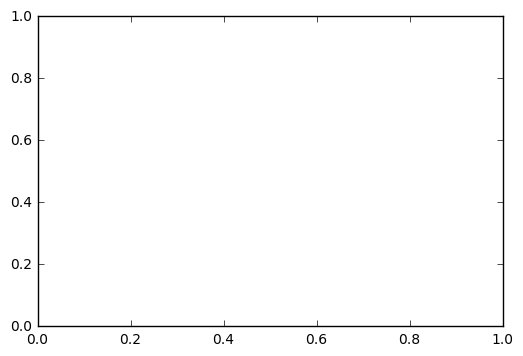

In [8]:
def draw_image(i):
    plot_mnist_digit(images_train[i])
    print(i, ':', labels_train[i])
interact(draw_image, i=(0, len(images_train)-1))

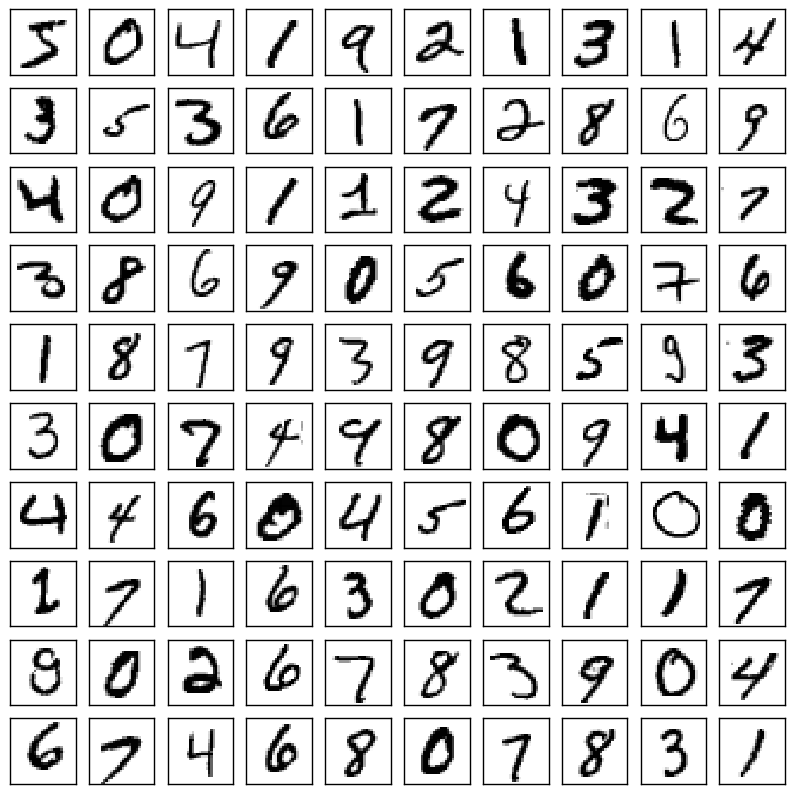

In [9]:
plot_10_by_10_images(images_train, figsize=(10,10))

In [10]:
def to_features(X):
    return X.reshape(-1, 784).astype("float32") / 255.0

def to_images(X):
    return (X*255.0).astype('uint8').reshape(-1, 28, 28)

#print((images_train[0]-(to_images(to_features(images_train[0])))).max())
print('data shape:', images_train.shape)
print('features shape', to_features(images_train).shape)

data shape: (60000, 28, 28)
features shape (60000, 784)


In [11]:
# the data, shuffled and split between train and test sets
X_train = to_features(images_train)
X_test = to_features(images_test)
print(X_train.shape, 'training samples')
print(X_test.shape, 'test samples')

(60000, 784) training samples
(10000, 784) test samples


In [12]:
# The labels need to be transformed into class indicators
from keras.utils import np_utils
y_train = np_utils.to_categorical(labels_train, nb_classes=10)
y_test = np_utils.to_categorical(labels_test, nb_classes=10)
print(y_train.shape, 'train labels')
print(y_test.shape, 'test labels')

(60000, 10) train labels
(10000, 10) test labels


In [13]:
print('labels', labels_train[:3])
print('y', y_train[:3])

labels [5 0 4]
y [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [14]:
# Neural Network Architecture Parameters
nb_input = 784
nb_hidden = 512
nb_output = 10
# Training Parameters
nb_epoch = 10
batch_size = 128

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
mlp = Sequential()
mlp.add(Dense(output_dim = nb_hidden, input_dim=nb_input, init='uniform'))
mlp.add(Activation('sigmoid'))
mlp.add(Dense(output_dim=nb_output, input_dim=nb_hidden, init='uniform'))
mlp.add(Activation('softmax'))

In [16]:
mlp.compile(loss='categorical_crossentropy', optimizer='SGD')

In [17]:
mlp.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
       verbose=1)

Epoch 1/10
60000/60000 [==============================] - 2s - loss: 2.1749     
Epoch 2/10
60000/60000 [==============================] - 1s - loss: 1.8553     
Epoch 3/10
60000/60000 [==============================] - 1s - loss: 1.4792     
Epoch 4/10
60000/60000 [==============================] - 1s - loss: 1.1625     
Epoch 5/10
60000/60000 [==============================] - 1s - loss: 0.9473     
Epoch 6/10
60000/60000 [==============================] - 1s - loss: 0.8071     
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.7126     
Epoch 8/10
60000/60000 [==============================] - 1s - loss: 0.6456     
Epoch 9/10
60000/60000 [==============================] - 1s - loss: 0.5958     
Epoch 10/10
60000/60000 [==============================] - 1s - loss: 0.5576     


In [18]:
scores = mlp.evaluate(X_test, y_test, verbose=0)

5002 : 	predict 9 	actual: 9


<function __main__.draw_mlp_prediction>

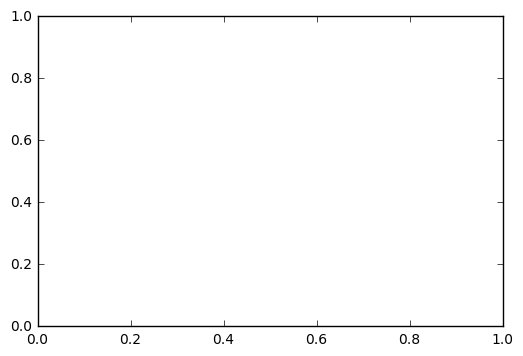

In [19]:
def draw_mlp_prediction(j):
    plot_mnist_digit(to_images(X_test)[j])
    prediction = mlp.predict_classes(X_test[j:j+1], verbose=False)[0]
    print(j, ':', '\tpredict', prediction, '\tactual:', labels_test[j])

interact(draw_mlp_prediction, j=(5, len(X_test)-1))
    

In [20]:
print (scores)

0.520979654074


### Manual Autoencoder

In [21]:
from keras.layers.core import Dropout

In [22]:
mae = Sequential()
nb_layers = 2
encoder = []
decoder = []
for i in range(nb_layers):
    if i > 0:
        encoder.append(Dropout(0.4))
    encoder.append(Dense(output_dim=nb_hidden/nb_layers,
                        input_dim=nb_input if i==0 else nb_hidden/nb_layers,
                        init='glorot_uniform'))
    encoder.append(Activation('sigmoid'))
    
    decoder.append(Activation('sigmoid'))
    decoder.append(Dense(output_dim=nb_input if i==0 else nb_hidden/nb_layers,
                        input_dim=nb_hidden/nb_layers,
                        init='glorot_uniform'))
    
print(encoder)

for layer in encoder:
    mae.add(layer)
for layer in reversed(decoder):
    mae.add(layer)

[<keras.layers.core.Dense object at 0x7fdea0ecc610>, <keras.layers.core.Activation object at 0x7fdea0ecc390>, <keras.layers.core.Dropout object at 0x7fdea0ecc350>, <keras.layers.core.Dense object at 0x7fdea0ecc290>, <keras.layers.core.Activation object at 0x7fdea0ecc3d0>]


In [23]:
from keras.optimizers import SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

In [24]:
mae.compile(loss='mse', optimizer=sgd)

In [25]:
mae.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.0876     
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.0681     
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.0677     
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.0675     
Epoch 5/10
60000/60000 [==============================] - 2s - loss: 0.0675     
Epoch 6/10
60000/60000 [==============================] - 2s - loss: 0.0674     
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.0674     
Epoch 8/10
60000/60000 [==============================] - 2s - loss: 0.0674     
Epoch 9/10
60000/60000 [==============================] - 2s - loss: 0.0673     
Epoch 10/10
60000/60000 [==============================] - 2s - loss: 0.0673     


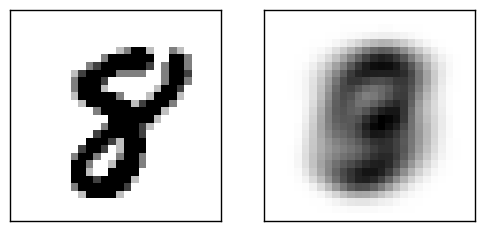

<function __main__.draw_mae_prediction>

In [30]:
def draw_mae_prediction(j):
    X_plot = X_test[j:j+1]
    prediction = mae.predict(X_plot, verbose=False)
    plot_1_by_2_images(to_images(X_plot)[0], to_images(prediction)[0])
interact(draw_mae_prediction, j=(7, len(X_test)-1))

### Stacked Autoencoder

In [31]:
class StackedAutoencoder:
    
    def __init__(self, layers, mode='autoencoder',
                activation='sigmoid', init='uniform', final_activation='softmax',
                dropout=0.2, optimizer='SGD'):
        self.layers = layers
        self.mode = mode
        self.activation = activation
        self.final_activation = final_activation
        self.init = init
        self.dropout = dropout
        self.optimizer = optimizer
        self._model = None
        
        self.build()
        self.compile()
        

        
    def _add_layer(self, model, i, is_encoder):
        if is_encoder:
            input_dim, output_dim = self.layers[i], self.layers[i+1]
            activation = self.final_activation if i==len(self.layers)-2 else self.activation
        else:
            input_dim, output_dim = self.layers[i+1], self.layers[i]
            activation = self.activation
        model.add(Dense(output_dim=output_dim,
                        input_dim=input_dim,
                        init=self.init))
        model.add(Activation(activation))
            
    def build(self):
        self.encoder = Sequential()
        self.decoder = Sequential()
        self.autoencoder = Sequential()
        for i in range(len(self.layers)-1):
            self._add_layer(self.encoder, i, True)
            self._add_layer(self.autoencoder, i, True)
                
        for i in reversed(range(len(self.layers)-1)):
            self._add_layer(self.decoder, i, False)
            self._add_layer(self.autoencoder, i, False)
                
    def compile(self):
        print("compiling encoder ...")
        self.encoder.compile(loss='categorical_crossentropy', optimizer=self.optimizer)
        print("Compiling decoder ...")
        self.decoder.compile(loss="mse", optimizer=self.optimizer)
        print("Compiling autoencoder ...")
        return self.autoencoder.compile(loss='mse', optimizer=self.optimizer)
        
    def fit(self, X_train, Y_train, batch_size, nb_epoch, verbose=1):
        result = self.autoencoder.fit(X_train, Y_train,
                                      batch_size=batch_size, nb_epoch=nb_epoch,
                                      verbose=verbose)
        #copy the weights to the encoder
        for i, l in enumerate(self.encoder.layers):
            l.set_weights(self.autoencoder.layers[i].get_weights())
        for i in range(len(self.decoder.layers)):
            self.decoder.layers[-1-i].set_weights(self.autoencoder.layers[-1-i].get_weights())
        return result
        
    def pretrain(self, X_train, batch_size, nb_epoch, verbose=1):
        for i in range(len(self.layers)-1):
            # Greedily train each layer
            print("Now pretraining layer {} [{}--->{}]".format(i+1, self.layers[i],
                                                                   self.layers[i+1]))
            ae = Sequential()
            self._add_layer(ae, i, True)
            self._add_layer(ae, i, False)
            ae.compile(loss='mse', optimizer=self.optimizer)
            ae.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=verbose)
            # Then lift the training data up one layer
            print("Transforming data from", X_train.shape, "to", (X_train.shape[0], self.layers[i+1]))
            enc = Sequential()
            self._add_layer(enc, i, True)
            enc.compile(loss='mse', optimizer=self.optimizer)
            enc.layers[0].set_weights(ae.layers[0].get_weights())
            enc.layers[1].set_weights(ae.layers[1].get_weights())
            X_train = enc.predict(X_train, verbose=verbose)
            print("Shape check:", X_train.shape)
            # Then copy the learned weights
            self.encoder.layers[2*i].set_weights(ae.layers[0].get_weights())
            self.encoder.layers[2*i+1].set_weights(ae.layers[1].get_weights())
            self.autoencoder.layers[2*i].set_weights(ae.layers[0].get_weights())
            self.autoencoder.layers[2*i+1].set_weights(ae.layers[1].get_weights())
            self.decoder.layers[-1-(2*i)].set_weights(ae.layers[-1].get_weights())
            self.decoder.layers[-1-(2*i+1)].set_weights(ae.layers[-2].get_weights())
                
    def evaluate(self, X_test, Y_test, show_accuracy=False):
        return self.autoencoder.evaluate(X_test, Y_test, verbose=1, show_accuracy=show_accuracy)
        
    def predict(self, X, verbose=False):
        return self.autoencoder.predict(X, verbose=verbose)
        
    def _get_paths(self, name):
        model_path = "models/{}_model.yaml".format(name)
        weights_path = "models/{}_weights.hdf5".format(name)
        return model.path, weights_path
        
    def save(self, name='autoencoder'):
        model_path, weights_path = self._get_paths(name)
        open(model_path, 'w').write(self.autoencoder.to_yaml())
        self.autoencoder.save_weights(weights_path, overwrite=True)
            
    def load(self, name='autoencoder'):
        model_path, weights_path = self._get_paths(name)
        self.autoencoder = keras.models.model_from_yaml(open(model_path))
        self.autoencoder.load_weights(weights_path)
            
        

In [32]:
sae = StackedAutoencoder(layers=[nb_input,10],
                         activation='sigmoid',
                         final_activation='sigmoid',
                         init='uniform',
                         dropout=0.2,
                         optimizer='adam')

compiling encoder ...
Compiling decoder ...
Compiling autoencoder ...


In [33]:
sae.pretrain(X_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

Now pretraining layer 1 [784--->10]
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.0961     
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.0691     
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.0679     
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.0676     
Epoch 5/10
60000/60000 [==============================] - 2s - loss: 0.0675     
Epoch 6/10
60000/60000 [==============================] - 2s - loss: 0.0674     
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.0674     
Epoch 8/10
60000/60000 [==============================] - 2s - loss: 0.0673     
Epoch 9/10
60000/60000 [==============================] - 2s - loss: 0.0673     
Epoch 10/10
60000/60000 [==============================] - 2s - loss: 0.0673     
Transforming data from (60000, 784) to (60000, 10)
59968/60000 [============================>.] - ETA: 0sShape check: (60000, 10)


In [64]:
sae.fit(X_train, X_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 3s - loss: 0.0672     
Epoch 2/10
60000/60000 [==============================] - 3s - loss: 0.0609     
Epoch 3/10
60000/60000 [==============================] - 3s - loss: 0.0580     
Epoch 4/10
60000/60000 [==============================] - 3s - loss: 0.0537     
Epoch 5/10
60000/60000 [==============================] - 3s - loss: 0.0493     
Epoch 6/10
60000/60000 [==============================] - 3s - loss: 0.0457     
Epoch 7/10
60000/60000 [==============================] - 3s - loss: 0.0426     
Epoch 8/10
60000/60000 [==============================] - 3s - loss: 0.0379     
Epoch 9/10
60000/60000 [==============================] - 3s - loss: 0.0347     
Epoch 10/10
60000/60000 [==============================] - 3s - loss: 0.0325     


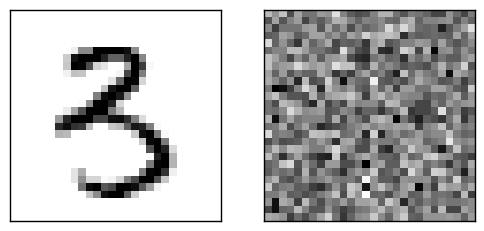

[ 0.99999678  0.99999702  0.99999464  0.99999452  0.99999213  0.99999356
  0.99999523  0.99999368  0.99999344  0.99999607]


<function __main__.draw_sae_prediction>

In [34]:
def draw_sae_prediction(j):
    X_plot = X_test[j:j+1]
    prediction = sae.predict(X_plot, verbose=False)
    plot_1_by_2_images(to_images(X_plot)[0], to_images(prediction)[0])
    print(sae.encoder.predict(X_plot, verbose=False)[0])
interact(draw_sae_prediction, j=(2, len(X_test)-1))

In [1]:
sae.evaluate(X_test, X_test, show_accuracy=True)

NameError: name 'sae' is not defined